In [1]:
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt

from statsmodels.stats.proportion import proportion_confint, proportions_ztest, \
confint_proportions_2indep, test_proportions_2indep

## One sample

In episode 5 of season 13 of Mythbusters they tested the expression "know something like the back of one's hand". 

12 subjects tried to select a photo of their hand from 10 similar pictures.
11 of 12 subjects selected their own hand. 

### Confidence interval
Confidence interval for the proportion of people knowing what the back of their hand looks like:

In [2]:
print("Wald's interval:", proportion_confint(11, 12, method = 'normal'))
print("Wilson's interval:", proportion_confint(11, 12, method = 'wilson'))

Wald's interval: (0.7602897792479355, 1.0)
Wilson's interval: (0.646120088858883, 0.9851349055950829)


In this implementation of the Wald's interval the result is trimmed so both limits are within [0,1].

How many subjects do we need to test if we want an estimate with +- 5% precision (i.e., 95% confidence interval of the width up to 10%)? statsmodels has a function to calculate that (only for Wald's method, unfortunately):

In [3]:
from statsmodels.stats.proportion import samplesize_confint_proportion

That number of subjects depends on the unknown true proprotion that we are trying to estimate; let's plot sample size as a function of the unknown proportion:

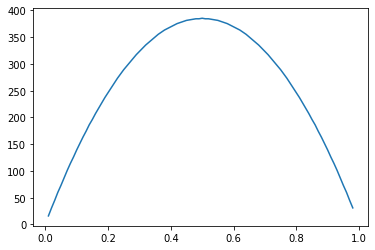

In [4]:
prop = np.arange(0.01, 0.99, 0.01)
n = [np.ceil(samplesize_confint_proportion(p, 0.05)) for p in prop]

plt.plot(prop, n);

### Test

Let's test a hypothesis now!

$H_0$: people do not know what backs of their hands look like and are guessing at random ($p=0.1$).

$H_1$: people are able to select a picture of their own hand better than at random ($p>0.1$).

In [5]:
print('Z test:', proportions_ztest(11, 12, value = 0.1, alternative='larger'))

Z test: (10.235766170195031, 6.85528054545589e-25)


The function outputs the value of Z statistic and the corersponding p-value.

## Two samples, independent

The same experiment was run with the pictures of palms. 7 of 12 subjects selected a picture of their own palm. 

### Confidence interval

Confidence interval for the difference in proportions of people knowing back of their hands and palms:

In [6]:
print("Wald's interval:", confint_proportions_2indep(11, 12, 7, 12, method = 'wald', compare='diff'))

Wald's interval: (0.013550506137431695, 0.6531161605292348)


In theory, the same function implements Wilson's interval too. In practice, at the moment (statsmodels version 0.12.0) this function does not work:

In [7]:
print("Wilson's interval:", confint_proportions_2indep(11, 12, 7, 12, method = 'score', compare='diff'))

ValueError: f(a) and f(b) must have different signs

Oh well! Did I mention that anything statistics related works much better in R?

### Test

$𝐻_0$ : the same proportion of people are able to select a picture of their palms and backs of their hands( $p_1=p_2$ ).

$𝐻_1$ : people are more likely to identify a picture of the back of their hand than of the palm  ( $p_1>p_2$ ).

In [8]:
print("Z test:", test_proportions_2indep(11, 12, 7, 12, alternative = 'larger',
                                          method = 'wald',  return_results=False))

Z test: (2.0430156738209964, 0.020525443280229438)


In [9]:
print("Wilson's interval based test:", 
      test_proportions_2indep(11, 12, 7, 12, alternative = 'larger', 
                              method = 'score', correction=False, return_results=False))

Wilson's interval based test: (1.845916413981794, 0.0324521714914821)


## Two samples, paired

We could use confidence interval for paired samples, but the problem is that we don't know the pairings (i.e., how many people correctly guessed the palm, but not back, and vice versa. 

Given our samples though, there aren't that many options!  

Option one:

| Back \ Palm | Right | Wrong | Total |
|-------------|-------|-------|-------|
| Right       | 6     | 5     | 11    |
| Wrong       | 1     | 0     | 1     |
| Total       | 7     | 5     | 12    | 

Option two:

| Back \ Palm | Right | Wrong | Total |
|-------------|-------|-------|-------|
| Right       | 7     | 4     | 11    |
| Wrong       | 0     | 1     | 1     |
| Total       | 7     | 5     | 12    | 

There are no other tables that have the same marginal totals.

### Confidence interval

Let's build confidence intervals for differences in proportions for both!

In [10]:
def confint_proportions_2paired_wald(b, c, n, alpha = 0.05):
    z = sc.stats.norm.ppf(1 - alpha / 2.)
 
    CI_l = float(b - c) / n  - z * np.sqrt(float((b + c)) / n**2 - float((b - c)**2) / n**3)
    CI_u = float(b - c) / n  + z * np.sqrt(float((b + c)) / n**2 - float((b - c)**2) / n**3)
    return (CI_l, CI_u)

print("Wald's interval for option 1:", confint_proportions_2paired_wald(5, 1, 12))
print("Wald's interval for option 2:", confint_proportions_2paired_wald(4, 0, 12))

Wald's interval for option 1: (-0.019500510056176756, 0.6861671767228434)
Wald's interval for option 2: (0.06661601798026057, 0.6000506486864061)


### Tests
We'll test the same hypothesis now, but using a test for paired samples!

$𝐻_0$ : the same proportion of people are able to select a picture of their palms and backs of their hands( $p_1=p_2$ ).

$𝐻_1$ : people are more likely to identify a picture of the back of their hand than of the palm  ( $p_1>p_2$ ).

In [11]:
def test_proportions_2paired_wald(b, c, n, alternative = 'two-sided'):  
    if alternative not in ('two-sided', 'smaller', 'larger'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'smaller' or 'larger'")
        
    z = float(b - c) / np.sqrt(b + c - float((b - c)**2) / n )
    
    if alternative == 'two-sided':
        p = 2 * (1 - sc.stats.norm.cdf(np.abs(z)))
    
    if alternative == 'smaller':
        p = sc.stats.norm.cdf(z)

    if alternative == 'larger':
        p = 1 - sc.stats.norm.cdf(z)
    
    return(z,p)
    
print("Z test for option 1:", test_proportions_2paired_wald(5, 1, 12, alternative = 'larger'))
print("Z test for option 2:", test_proportions_2paired_wald(4, 0, 12, alternative = 'larger'))

Z test for option 1: (1.8516401995451028, 0.03203875322552974)
Z test for option 2: (2.449489742783178, 0.007152939217714871)
